# **Libraries**

In [4]:
# Run this only once
!pip install kagglehub nltk tensorflow --quiet

import kagglehub
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, GRU, Bidirectional

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')  # Add this to fix the error


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# **Load dataset**

In [27]:
# Load from KaggleHub
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
df = pd.read_csv(path + "/IMDB Dataset.csv")

# Sample 14,500 (12k train, 2.5k test)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle entire dataset

# Preview
df.head()


,review,sentiment
0,I really liked this Summerslam due to the look...,positive
1,Not many television shows appeal to quite as m...,positive
2,The film quickly gets to a major chase scene w...,negative
3,Jane Austen would definitely approve of this o...,positive
4,Expectations were somewhat high for me when I ...,negative


In [28]:
# Preview
df.head()

,review,sentiment
0,I really liked this Summerslam due to the look...,positive
1,Not many television shows appeal to quite as m...,positive
2,The film quickly gets to a major chase scene w...,negative
3,Jane Austen would definitely approve of this o...,positive
4,Expectations were somewhat high for me when I ...,negative


# **Preprocessing/Cleaning the data**

In [31]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # remove special chars
    words = word_tokenize(text)
    words = [stemmer.stem(w) for w in words if w not in stop_words]
    return ' '.join(words)

df['review'] = df['review'].astype(str).apply(preprocess_text)


In [32]:
df['review'][0]

'realli like summerslam due look arena curtain look overal interest reason anyway could one best summerslam ever wwf didnt lex luger main event yokozuna time ok huge fat man v strong man im glad time chang terribl main event like everi match luger terribl match card razor ramon v ted dibias steiner brother v heavenli bodi shawn michael v curt hene event shawn name big monster bodi guard diesel ir v kid bret hart first take doink take jerri lawler stuff hart lawler alway interest ludvig borga destroy marti jannetti undertak took giant gonzalez anoth terribl match smoke gunn tatanka took bam bam bigelow headshrink yokozuna defend world titl lex luger match bore terribl end howev deserv'

# **Encode Labels + Tokenizet**

In [35]:
# Encode sentiment
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])  # pos=1, neg=0

# Tokenize
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['review'])

sequences = tokenizer.texts_to_sequences(df['review'])
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Split
X_train, X_test, y_train, y_test = train_test_split(padded, df['sentiment'], test_size=0.2, random_state=42)


In [36]:
X_train[0]

array([ 651,   45,    3,  166,  317, 2146, 1552,  674,  280,   82,  724,
        118,  753, 1952,    4, 1486, 9245,   83, 4667, 1777,    3, 6040,
       3602, 7150,  219,  200,  304,  916,   82, 1028, 1242, 4067,  903,
        876,  998,   44,   43,    1,  894,  257,  503,   82,  724, 1905,
       2921,  304,   16,    1,    1,    3, 1440,   56,   48,  195, 4684,
        405,  545,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

# **Models**

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

# Add EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# **Simple RNN**

In [41]:
from tensorflow.keras.layers import SimpleRNN

# EarlyStopping already defined earlier
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_rnn = Sequential([
    Embedding(input_dim=8000, output_dim=64, input_length=80),
    SimpleRNN(64, return_sequences=True),
    Dropout(0.4),
    SimpleRNN(32),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.5101 - loss: 0.7180 - val_accuracy: 0.4910 - val_loss: 0.6974
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5261 - loss: 0.6916 - val_accuracy: 0.5596 - val_loss: 0.6765
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6337 - loss: 0.6386 - val_accuracy: 0.5409 - val_loss: 0.7079
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7247 - loss: 0.5216 - val_accuracy: 0.5110 - val_loss: 0.8381
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8276 - loss: 0.3523 - val_accuracy: 0.5195 - val_loss: 1.0468


# **BiLstm**

In [38]:
# Define BiLSTM model
model_bilstm = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(32)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Compile
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7497 - loss: 0.4888 - val_accuracy: 0.8650 - val_loss: 0.3336
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8967 - loss: 0.2703 - val_accuracy: 0.8649 - val_loss: 0.3207
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9230 - loss: 0.2021 - val_accuracy: 0.8573 - val_loss: 0.3600
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9448 - loss: 0.1575 - val_accuracy: 0.8582 - val_loss: 0.3920
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9551 - loss: 0.1284 - val_accuracy: 0.8481 - val_loss: 0.4656


# **GRU**

In [39]:
model_gru = Sequential([
    Embedding(10000, 64, input_length=100),
    GRU(64, return_sequences=True),
    Dropout(0.4),
    GRU(32),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_gru = model_gru.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5564 - loss: 0.6664 - val_accuracy: 0.8398 - val_loss: 0.3700
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8625 - loss: 0.3389 - val_accuracy: 0.8665 - val_loss: 0.3179
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9153 - loss: 0.2307 - val_accuracy: 0.8660 - val_loss: 0.3290
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9423 - loss: 0.1692 - val_accuracy: 0.8618 - val_loss: 0.3741
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9597 - loss: 0.1258 - val_accuracy: 0.8567 - val_loss: 0.3962


# **Visualize Accuracy & Loss**

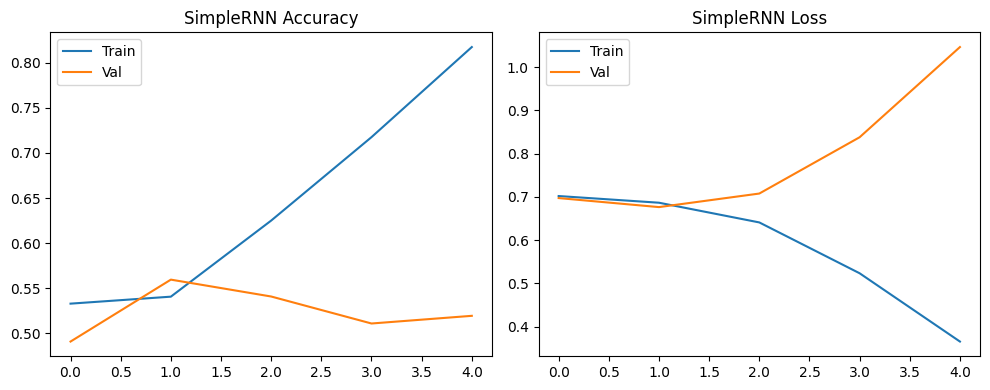

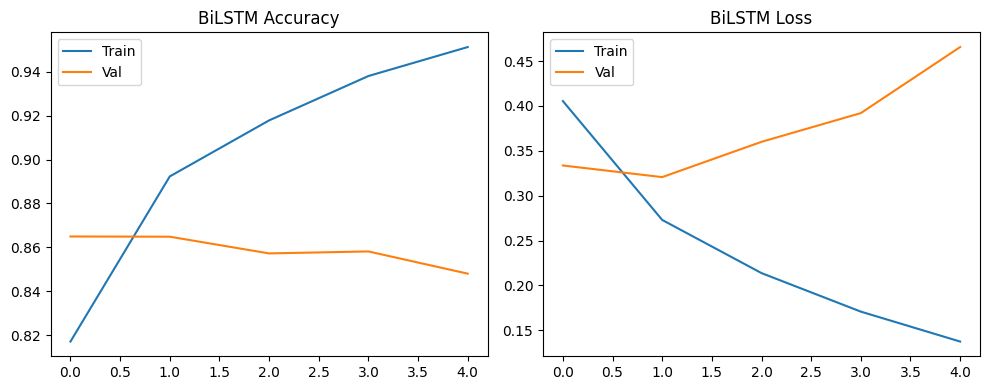

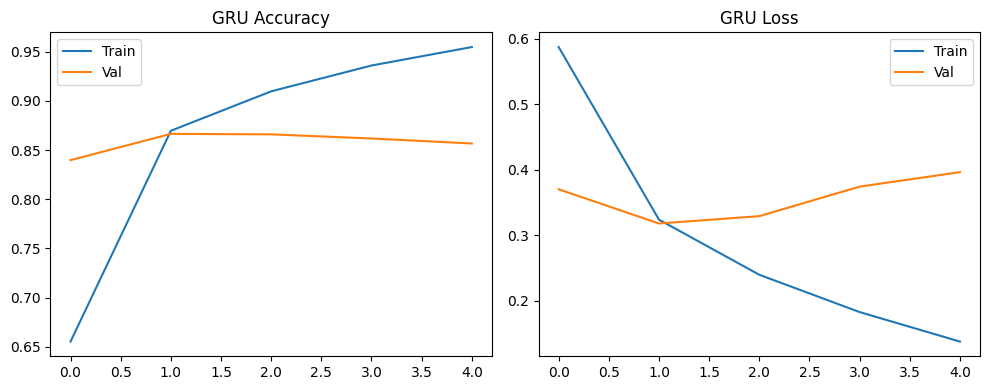

In [42]:
def plot_history(history, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_history(history_rnn, "SimpleRNN")
plot_history(history_bilstm, "BiLSTM")
plot_history(history_gru, "GRU")


# **Scores & Confusion Matrix**

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

SimpleRNN Classification Report:
              precision    recall  f1-score   support

    negative       0.57      0.47      0.51      4951
    positive       0.55      0.65      0.60      5049

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000



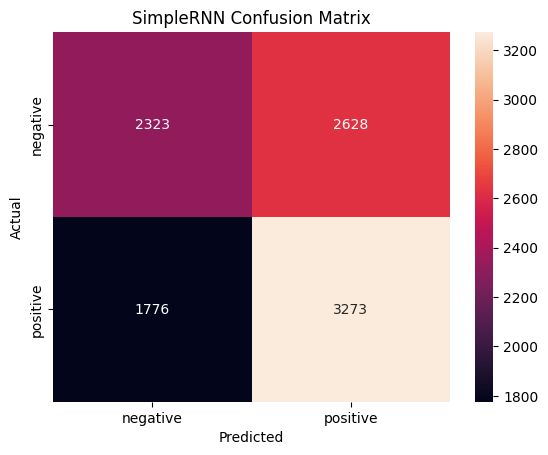

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

BiLSTM Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.84      0.86      4951
    positive       0.85      0.89      0.87      5049

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



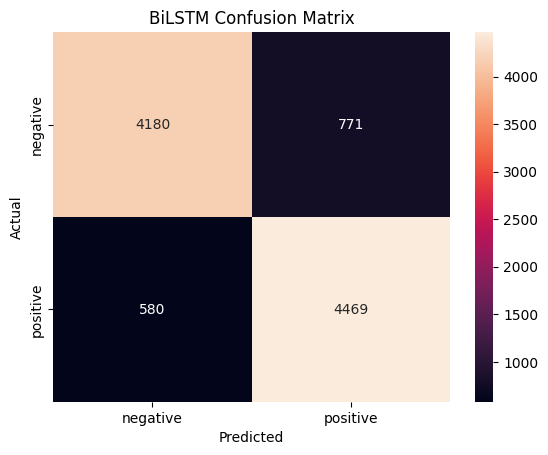

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

GRU Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.83      0.86      4951
    positive       0.85      0.90      0.87      5049

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



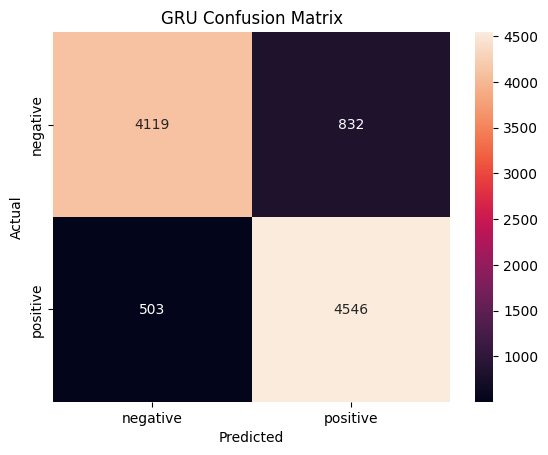

In [44]:
def evaluate_model(model, X, y_true, name):
    y_pred = (model.predict(X) > 0.5).astype(int)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['negative', 'positive']))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model(model_rnn, X_test, y_test, "SimpleRNN")
evaluate_model(model_bilstm, X_test, y_test, "BiLSTM")
evaluate_model(model_gru, X_test, y_test, "GRU")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


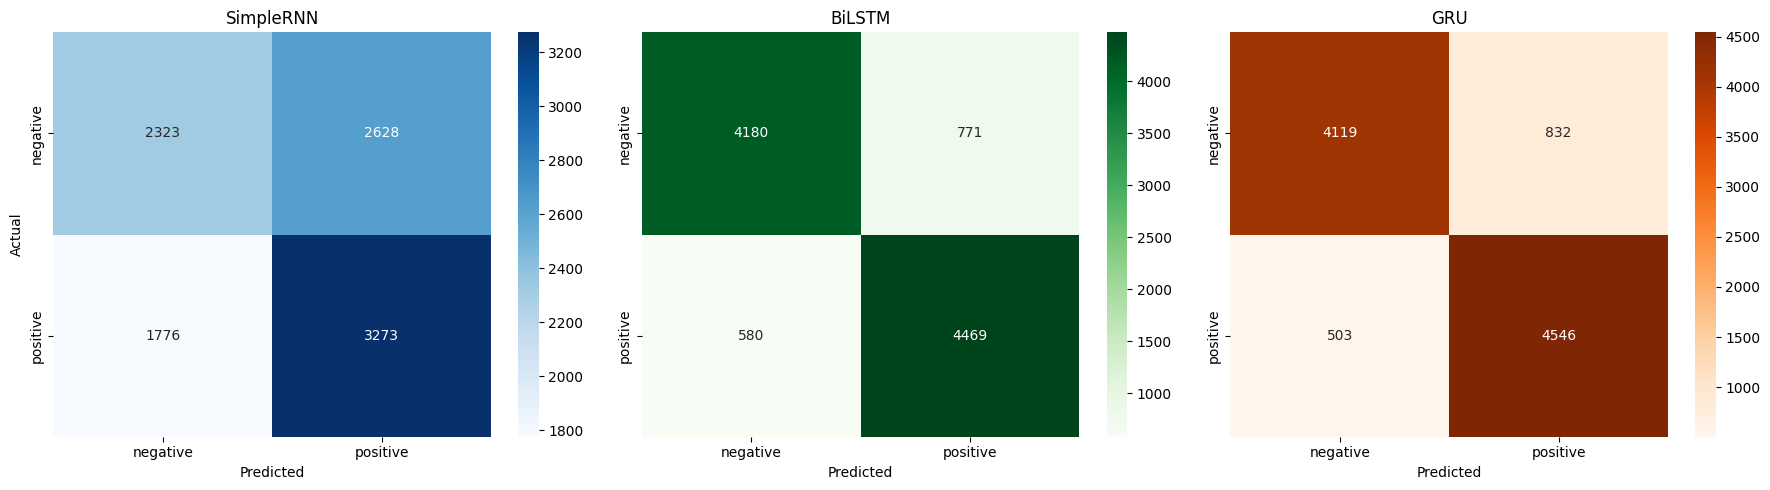

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred_rnn = (model_rnn.predict(X_test) > 0.5).astype(int)
y_pred_bilstm = (model_bilstm.predict(X_test) > 0.5).astype(int)
y_pred_gru = (model_gru.predict(X_test) > 0.5).astype(int)

# Compute confusion matrices
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
cm_bilstm = confusion_matrix(y_test, y_pred_bilstm)
cm_gru = confusion_matrix(y_test, y_pred_gru)

# Set up subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Heatmap for SimpleRNN
sns.heatmap(cm_rnn, annot=True, fmt='d', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'], ax=axs[0], cmap='Blues')
axs[0].set_title('SimpleRNN')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

# Heatmap for BiLSTM
sns.heatmap(cm_bilstm, annot=True, fmt='d', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'], ax=axs[1], cmap='Greens')
axs[1].set_title('BiLSTM')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('')

# Heatmap for GRU
sns.heatmap(cm_gru, annot=True, fmt='d', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'], ax=axs[2], cmap='Oranges')
axs[2].set_title('GRU')
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('')

# Display
plt.tight_layout()
plt.show()


In [45]:
from sklearn.metrics import accuracy_score
import pandas as pd

# Predictions
y_pred_rnn = (model_rnn.predict(X_test) > 0.5).astype(int)
y_pred_bilstm = (model_bilstm.predict(X_test) > 0.5).astype(int)
y_pred_gru = (model_gru.predict(X_test) > 0.5).astype(int)

# Accuracies
acc_rnn = accuracy_score(y_test, y_pred_rnn)
acc_bilstm = accuracy_score(y_test, y_pred_bilstm)
acc_gru = accuracy_score(y_test, y_pred_gru)

# Create a DataFrame
accuracy_table = pd.DataFrame({
    'Model': ['SimpleRNN', 'BiLSTM', 'GRU'],
    'Accuracy': [acc_rnn, acc_bilstm, acc_gru]
})

# Display table
accuracy_table.sort_values(by='Accuracy', ascending=False, inplace=True)
print(accuracy_table)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
       Model  Accuracy
2        GRU    0.8665
1     BiLSTM    0.8649
0  SimpleRNN    0.5596


# **Save model and tokenizer**

In [47]:
# Save GRU model
model_gru.save("sentiment_model_gru.h5")
print("Model saved as sentiment_model_gru.h5")


Model saved as sentiment_model_gru.h5


In [48]:
import pickle

# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Tokenizer saved as tokenizer.pkl")


Tokenizer saved as tokenizer.pkl
